# Predicting NYC Taxi Fares with RAPIDS

RAPIDS is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

This notebook focuses on showing how to use cuDF with Dask & XGBoost to scale GPU DataFrame ETL-style operations & model training out to multiple GPUs on mutliple nodes as part of Google Cloud Dataproc.

Anaconda has graciously made some of the NYC Taxi dataset available in a public Google Cloud Storage bucket. We'll use our Dataproc Cluster of GPUs to process it and train a model that predicts the fare amount.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cupy
import numba, socket, time
import cudf
import dask, dask_cudf
import xgboost as xgb
import cuspatial
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster


# connect to the Dask cluster created at Dataproc startup time
client = Client(socket.gethostname()+':8786')

# if you're not using Dataproc, you can use dask_cuda to create a local CUDA cluster as well
# as shown in the commented code below. Check https://github.com/rapidsai/dask-cuda for help

# cluster = LocalCUDACluster()
# client = Client(cluster)

# forces workers to restart. useful to ensure GPU memory is clear
client.restart()

# limit work-stealing as much as possible
dask.config.set({'distributed.scheduler.work-stealing': False})
dask.config.get('distributed.scheduler.work-stealing')
dask.config.set({'distributed.scheduler.bandwidth': 1})
dask.config.get('distributed.scheduler.bandwidth')

client

distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:40945 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 540.94 GB


# Inspecting the Data

Now that we have a cluster of GPU workers, we'll use [dask-cudf](https://github.com/rapidsai/dask-cudf/) to load and parse a bunch of CSV files into a distributed DataFrame. 

In [2]:
'''if you get 'ModuleNotFoundError: No module named 'gcsfs', run `!pip install gcsfs` 
'''
base_path = 'gcs://anaconda-public-data/nyc-taxi/csv/'

df_2014 = dask_cudf.read_csv(base_path+'2014/yellow_*.csv')
df_2014.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns. The 2015 CSVs have `tpep_pickup_datetime` and `tpep_dropoff_datetime`, which are the same columns. One year has `rate_code`, and another `RateCodeID`.

Also, some CSV files have column names with extraneous spaces in them.

Worst of all, starting in the July 2016 CSVs, pickup & dropoff latitude and longitude data were replaced by location IDs, making the second half of the year useless to us.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [3]:
#Dictionary of required columns and their datatypes
must_haves = {
     'pickup_datetime': 'datetime64[s]',
     'dropoff_datetime': 'datetime64[s]',
     'passenger_count': 'int32',
     'trip_distance': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'rate_code': 'int32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'fare_amount': 'float32'
    }

In [4]:
def clean(ddf, must_haves):
    # replace the extraneous spaces in column names and lower the font type
    tmp = {col:col.strip().lower() for col in list(ddf.columns)}
    ddf = ddf.rename(columns=tmp)

    ddf = ddf.rename(columns={
        'tpep_pickup_datetime': 'pickup_datetime',
        'tpep_dropoff_datetime': 'dropoff_datetime',
        'ratecodeid': 'rate_code'
    })
    
    ddf['pickup_datetime'] = ddf['pickup_datetime'].astype('datetime64[ms]')
    ddf['dropoff_datetime'] = ddf['dropoff_datetime'].astype('datetime64[ms]')

    for col in ddf.columns:
        if col not in must_haves:
            ddf = ddf.drop(columns=col)
            continue
        # if column was read as a string, recast as float
        if ddf[col].dtype == 'object':
            ddf[col] = ddf[col].str.fillna('-1')
            ddf[col] = ddf[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(ddf[col].dtype):
                ddf[col] = ddf[col].astype('int32')
            if 'float' in str(ddf[col].dtype):
                ddf[col] = ddf[col].astype('float32')
            ddf[col] = ddf[col].fillna(-1)
    
    return ddf

<b> NOTE: </b>We will realize that some of 2015 data has column name as `RateCodeID` and others have `RatecodeID`. When we rename the columns in the clean function, it internally doesn't pass meta while calling map_partitions(). This leads to the error of column name mismatch in the returned data. For this reason, we will call the clean function with map_partition and pass the meta to it. Here is the link to the bug created for that: https://github.com/rapidsai/cudf/issues/5413 

In [5]:
df_2014 = df_2014.map_partitions(clean, must_haves, meta=must_haves)

We still have 2015 and the first half of 2016's data to read and clean. Let's increase our dataset.

In [6]:
df_2015 = dask_cudf.read_csv(base_path+'2015/yellow_*.csv')

In [7]:
df_2015 = df_2015.map_partitions(clean, must_haves, meta=must_haves)

# Handling 2016's Mid-Year Schema Change

In 2016, only January - June CSVs have the columns we need. If we try to read base_path+2016/yellow_*.csv, Dask will not appreciate having differing schemas in the same DataFrame.

Instead, we'll need to create a list of the valid months and read them independently.

In [8]:
months = [str(x).rjust(2, '0') for x in range(1, 7)]
valid_files = [base_path+'2016/yellow_tripdata_2016-'+month+'.csv' for month in months]

In [9]:
#read & clean 2016 data and concat all DFs
df_2016 = dask_cudf.read_csv(valid_files).map_partitions(clean, must_haves, meta=must_haves)

#concatenate multiple DataFrames into one bigger one
taxi_df = dask.dataframe.multi.concat([df_2014, df_2015, df_2016])

In [10]:
taxi_df = taxi_df.persist()

## Exploratory Data Analysis (EDA)

Here, we are checking out if there are any non-sensical records and outliers, and in such case, we need to remove them from the dataset.

In [11]:
# check out if there is any negative total trip time
taxi_df[taxi_df.dropoff_datetime <= taxi_df.pickup_datetime].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
3832,2014-01-09 20:27:41,2014-01-09 19:05:21,1,1.8,0.000000,0.000000,1,-73.969589,40.789001,9.5
16134,2014-01-09 22:15:40,2014-01-09 22:15:14,1,1.3,0.000000,0.000000,1,-74.002861,40.760624,7.5
16181,2014-01-09 22:27:13,2014-01-09 22:26:49,1,1.9,0.000000,0.000000,1,-73.976288,40.741631,8.5
16873,2014-01-10 00:14:23,2014-01-10 00:14:23,1,0.7,-74.005135,40.718693,1,-74.003876,40.728504,4.0
25248,2014-01-10 00:39:16,2014-01-10 00:38:59,1,1.5,0.000000,0.000000,1,-73.999283,40.733898,6.5


In [12]:
# check out if there is any abnormal data where trip distance is short, but the fare is very high.
taxi_df[(taxi_df.trip_distance < 10) & (taxi_df.fare_amount > 300)].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
373953,2014-01-12 15:03:38,2014-01-12 15:05:31,1,0.0,-73.823845,40.690258,5,-73.823845,40.690281,400.0
520658,2014-01-06 23:44:07,2014-01-06 23:45:01,1,0.0,-73.927902,41.677242,5,-73.927902,41.677242,370.0
525419,2014-01-06 23:50:28,2014-01-06 23:51:40,1,0.0,-73.927902,41.677242,5,-73.927902,41.677242,370.0
562916,2014-01-07 12:09:38,2014-01-07 12:10:27,1,0.0,-73.929695,40.812031,5,-73.929695,40.812031,500.0
576409,2014-01-07 16:35:10,2014-01-07 16:35:41,1,0.0,-73.996002,40.720932,5,-73.996010,40.720928,500.0


In [13]:
# check out if there is any abnormal data where trip distance is long, but the fare is very low.
taxi_df[(taxi_df.trip_distance > 50) & (taxi_df.fare_amount < 50)].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
11580,2014-01-09 22:22:14,2014-01-09 22:42:59,1,82.099998,-74.002174,40.751755,1,-73.964218,40.719555,20.0
33723,2014-01-10 05:43:48,2014-01-10 06:12:20,1,84.199997,-73.965050,40.806671,1,-73.957977,40.713139,34.5
122880,2014-01-10 18:16:53,2014-01-10 18:48:53,1,89.900002,-73.997185,40.742355,1,-73.948364,40.779270,21.5
226264,2014-01-11 13:22:07,2014-01-11 13:40:16,1,81.699997,-73.991684,40.759872,1,-73.994987,40.726055,13.5
290203,2014-01-11 20:12:50,2014-01-11 20:15:15,1,60.400002,-73.968109,40.770878,1,-73.972595,40.764606,4.0


In [14]:
#2016-01 data is used for visuals.
taxi_df_cdf = dask_cudf.read_csv(valid_files[0]).map_partitions(clean, must_haves, meta=must_haves).compute()
taxi_df_pd = taxi_df_cdf.to_pandas()

The plot below visualizes the histogram of trip_distance and we can see some abnormal trip_distance values for some records. Taking this and also the NYC map coordinates into consideration, we will only select records where tripdistance < 500 miles.

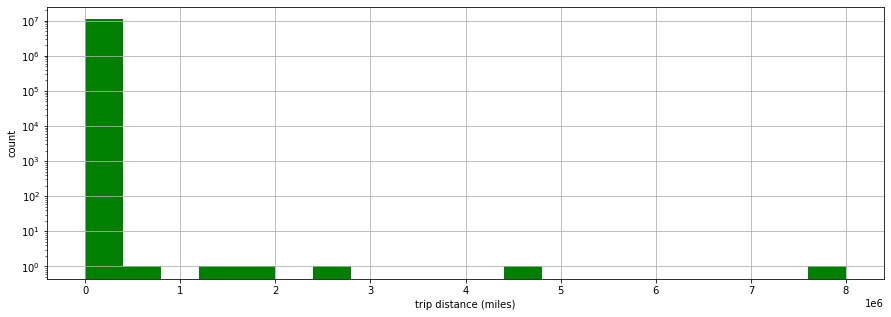

In [15]:
ax = taxi_df_pd['trip_distance'].hist(bins=20, figsize=(15,5), color='green')
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

Similarly, the plot below visualizes the histogram of fare_amount and we can see some abnormal fare_amount values for some records. Taking this and also the NYC map coordinates into consideration, we will only select records where fare_amount < 500$.

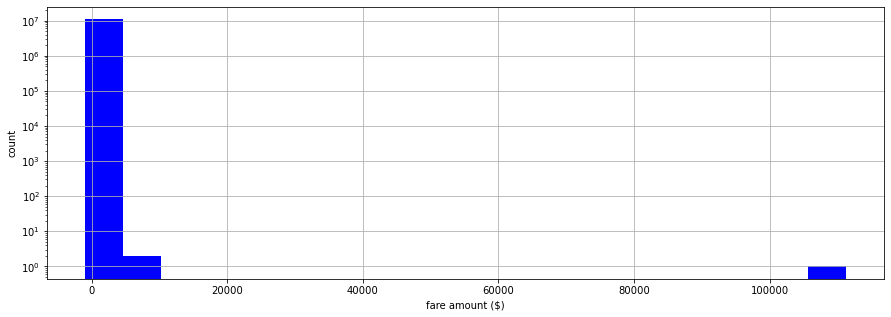

In [16]:
ax = taxi_df_pd['fare_amount'].hist(bins=20, figsize=(15,5), color='blue')
ax.set_yscale('log')
ax.set_xlabel("fare amount ($)")
ax.set_ylabel("count")
plt.show()

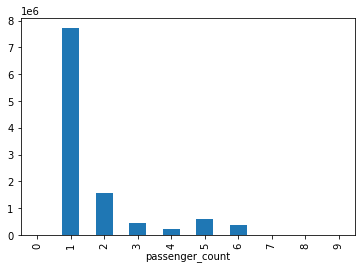

In [17]:
# Plot the number of passengers per trip. We'll remove the records where passenger_count > 5.
taxi_df_pd.groupby('passenger_count').size().plot(kind='bar')

EDA visuals and additional analysis yield the filter logic below.

In [18]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 1 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42',
    'trip_distance > 0 and trip_distance < 500',
    'not (trip_distance > 50 and fare_amount < 50)',
    'not (trip_distance < 10 and fare_amount > 300)',
    'not dropoff_datetime <= pickup_datetime'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

In [19]:
# reset_index and drop index column
taxi_df = taxi_df.reset_index(drop=True)
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994766,40.736828,1,-73.982224,40.731789,6.5
1,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982391,40.773380,1,-73.960449,40.763996,8.5
2,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988571,40.739407,1,-73.986626,40.765217,11.5
3,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770466,1,-73.979866,40.777050,7.5
4,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995369,40.717247,1,-73.984367,40.720524,6.0


# Adding Interesting Features

Dask & cuDF provide standard DataFrame operations, but also let you run "user defined functions" on the underlying data. Here we use [dask.dataframe's map_partitions](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions) to apply user defined python function on each DataFrame partition.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [20]:
## add features

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day
taxi_df['day_of_week'] = taxi_df['pickup_datetime'].dt.weekday
taxi_df['is_weekend'] = (taxi_df['day_of_week']>=5).astype('int32')

#calculate the time difference between dropoff and pickup.
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')
taxi_df['diff']=(taxi_df['diff']/1000).astype('int64')

taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude']//.01*.01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude']//.01*.01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude']//.01*.01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude']//.01*.01

taxi_df = taxi_df.drop('pickup_datetime', axis=1)
taxi_df = taxi_df.drop('dropoff_datetime', axis=1)

In [21]:
def haversine_dist(df):
    h_distance = cuspatial.haversine_distance(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
    df['h_distance']= h_distance
    df['h_distance']= df['h_distance'].astype('float32')
    return df

taxi_df = taxi_df.map_partitions(haversine_dist)
taxi_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,day_of_week,is_weekend,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance
0,1,0.7,-73.994766,40.736828,1,-73.982224,40.731789,6.5,20,2014,1,9,3,0,426,40.730000,-74.000000,40.730000,-73.989998,1.196175
1,1,1.4,-73.982391,40.773380,1,-73.960449,40.763996,8.5,20,2014,1,9,3,0,540,40.770000,-73.989998,40.759998,-73.970001,2.122098
2,2,2.3,-73.988571,40.739407,1,-73.986626,40.765217,11.5,20,2014,1,9,3,0,899,40.730000,-73.989998,40.759998,-73.989998,2.874643
3,1,1.7,-73.960213,40.770466,1,-73.979866,40.777050,7.5,20,2014,1,9,3,0,403,40.770000,-73.970001,40.770000,-73.979996,1.809662
4,1,0.9,-73.995369,40.717247,1,-73.984367,40.720524,6.0,20,2014,1,9,3,0,383,40.709999,-74.000000,40.719997,-73.989998,0.996204


In [22]:
taxi_df = taxi_df.persist()

# Pick a Training Set

Let's imagine you're making a trip to New York on the 25th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU cluster to load data from the Google Cloud Storage bucket and the ETL portion of the workflow.

In [23]:
#since we calculated the h_distance let's drop the trip_distance column, and then do model training with XGB.
taxi_df = taxi_df.drop('trip_distance', axis=1)

In [24]:
# this is the original data partition for train and test sets.
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_train, Y_train])

# Train the XGBoost Regression Model

The wall time output below indicates how long it took your GPU cluster to train an XGBoost model over the training set.

In [25]:
dtrain = xgb.dask.DaskDMatrix(client, X_train, Y_train)

In [ ]:
%%time

trained_model = xgb.dask.train(client,
                        {
                         'learning_rate': 0.3,
                          'max_depth': 8,
                          'objective': 'reg:squarederror',
                          'subsample': 0.6,
                          'gamma': 1,
                          'silent': True,
                          'verbose_eval': True,
                          'tree_method':'gpu_hist'
                        },
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train')])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgb.plot_importance(trained_model['booster'], height=0.8, max_num_features=10, importance_type="gain")
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
ax.set_xlabel('importance')
plt.show()

# How Good is Our Model?

Now that we have a trained model, we need to test it with the 25% of records we held out.

Based on the filtering conditions applied to this dataset, many of the DataFrame partitions will wind up having 0 rows. This is a problem for XGBoost which doesn't know what to do with 0 length arrays. We'll repartition the data. 

In [ ]:
def drop_empty_partitions(df):
    lengths = df.map_partitions(len).compute()
    nonempty = [length > 0 for length in lengths]
    return df.partitions[nonempty]

In [ ]:
X_test = taxi_df.query('day >= 25').persist()
X_test = drop_empty_partitions(X_test)

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']].persist()

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_test, Y_test])

# display test set size
len(X_test)

## Calculate Prediction

In [ ]:
# generate predictions on the test set
'''feed X_test as a dask.dataframe'''

booster = trained_model["booster"] # "Booster" is the trained model
history = trained_model['history'] # "History" is a dictionary containing evaluation results 

booster.set_param({'predictor': 'gpu_predictor'})

prediction = xgb.dask.predict(client, booster, X_test).persist()

wait(prediction)

prediction.head()

In [ ]:
pred = pred.map_partitions(lambda part: cudf.Series(part)).reset_index(drop=True)
true = Y_test['fare_amount'].reset_index(drop=True)

NOTE: We mapped each partition of the result from `xgb.dask.predict` into `cudf.Series` to be able to substract it from `true` data. Here is the issue asking XGBoost to solve that before returning data from `xgb.dask.predict` https://github.com/dmlc/xgboost/issues/5823#issuecomment-648526888

In [ ]:
pred.head()

In [ ]:
true.head()

In [ ]:
# Calculate RMSE
squared_error = ((pred-true)**2)

# compute the actual RMSE over the full test set
cupy.sqrt(squared_error.mean().compute())

## Save Trained Model for Later Use¶

To make a model maximally useful, you need to be able to save it for later use. We'll use Google Cloud Storage to persist the trained model in a dill file.

In [ ]:
import gcsfs, dill

fs = gcsfs.GCSFileSystem()
# replace with a bucket you own
bucket = 'rapidsai-test-1/'

with fs.open(bucket+'trained_model.dill', 'wb') as file:  
    dill.dump(trained_model, file)

As an alternative, you can save the trained model on your system as below.

In [ ]:
# Save the model to file
booster.save_model('xgboost-model')
print('Training evaluation history:', history)

## Reload a Saved Model from Disk

You can also read the saved model back out of Google Cloud Storage and into a normal XGBoost model object.

In [ ]:
with fs.open(bucket+'trained_model.dill', 'rb') as file:  
    model_from_disk = dill.load(file)

# Generate predictions on the test set again, but this time using the reloaded model
prediction = xgb.dask.predict(client, model_from_disk, X_test).persist()
wait(prediction)

# Verify that the predictions result in the same RMSE error
pred = pred.map_partitions(lambda part: cudf.Series(part)).reset_index(drop=True)
true = Y_test['fare_amount'].reset_index(drop=True)

squared_error = ((pred-true)**2)

# compute the actual RMSE over the full test set
cupy.sqrt(squared_error.mean().compute())

## VISUALS with CUXFILTER

In this section we will do visuzalizations using [cuxfilter (ku-cross-filter)](https://github.com/rapidsai/cuxfilter) which is a RAPIDS framework to connect web visualizations to GPU accelerated crossfiltering. Inspired by the javascript version of the original, it enables interactive and super fast multi-dimensional filtering of 100 million+ row tabular datasets via cuDF.

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
import cuxfilter as cxf
import datashader as ds
import datashader.transfer_functions as tf
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.charts import bokeh, datashader, panel_widgets
from colorcet import fire

In [ ]:
X_test_cudf= X_test.compute()
X_test_cudf['fare_amount']= Y_test['fare_amount'].compute()
X_test_cudf['prediction']= prediction.compute().values

In [ ]:
cux_df = cxf.DataFrame.from_dataframe(X_test_cudf)

label_map = {0.0: 'Mon',    1.0: 'Tues',    2.0: 'Wed',   3.0: 'Thu',    4.0: 'Fri', 5.0: 'Sat', 6.0: 'Sun'}

#declare charts
chart1 = cxf.charts.datashader.scatter_geo(x='pickup_longitude', y='pickup_latitude', aggregate_col='fare_amount', aggregate_fn='mean', color_palette=fire)
chart2 = cxf.charts.panel_widgets.multi_select('day_of_week')
chart3 = cxf.charts.bokeh.bar('day_of_week', x_label_map=label_map)
#chart3 = cxf.charts.panel_widgets.multi_select('month')
fare_vs_dist = cxf.charts.datashader.scatter(x='h_distance', y='prediction', x_range=(X_test_cudf['h_distance'].min(), X_test_cudf['h_distance'].max()), 
                                              y_range=(X_test_cudf['fare_amount'].min(), X_test_cudf['fare_amount'].max()))

#fare_vs_dist = cxf.charts.datashader.heatmap(x='pickup_longitude', y='pickup_latitude', aggregate_col='prediction', aggregate_fn='mean', color_palette=fire)

#declare dashboard
d = cux_df.dashboard([chart1, chart2, chart3, fare_vs_dist], layout=cxf.layouts.feature_and_double_base,theme = cxf.themes.light, 
                     title='Taxi Dataset', data_size_widget=True)

In [ ]:
#run the dashboard as a webapp. replace `jupyter-notebook/lab-url` with ipaddress:port of the jupyter session.
d.show('jupyter-notebook/lab-url')

In [ ]:
#d.stop()

In [ ]:
await d.preview()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
